## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [24]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [4]:
print(text[1])

  That thereby beauty's rose might never die,



Preprocessing of lines: lowercase + remove lines with roman numerals and other extra symbols

In [25]:
lines = text
lines = [el.lower() for el in lines]
min_len = 20
max_len = 60
lines = [line for line in lines if len(line) > min_len and len(line) < max_len] #filter lines

lines = [line.strip() + '\n' for line in lines]
print(lines[1])

that thereby beauty's rose might never die,



max length = 56


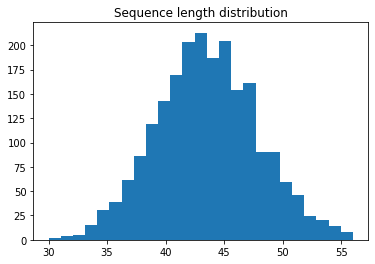

In [ ]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Lines length distribution')
plt.hist(list(map(len, lines)),bins=25);

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [11]:
# Join all the strings into one and lowercase it
# Put result into variable text.
# Your great code here
text_as_string = ''.join(text)
text = text_as_string.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-12-14 21:54:20--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2021-12-14 21:54:20 (11.7 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [12]:
tokens = sorted(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [13]:
# dict <index>:<char>
# Your great code here
indices = np.arange(38)
token_to_idx = dict(zip(tokens, indices))
print(token_to_idx)
# dict <char>:<index>
# Your great code here
idx_to_token = dict(zip(indices, tokens))
print(idx_to_token)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: ':', 10: ';', 11: '?', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w', 35: 'x', 36: 'y', 37: 'z'}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [41]:
def to_matrix(lines, max_len=None, pad=token_to_idx[' '], dtype='int64', batch_first = True):
    
    max_len = (max_len or max(map(len, lines))) + 1
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_idx[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    #if not batch_first: # convert [batch, time] into [time, batch]
        #names_ix = np.transpose(names_ix)

    return lines_ix

In [ ]:
#for one-hot-encoding version
def to_matrix(batch_letters, num_tokens = 38, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of chars into rnn-digestable matrix"""
    
    batch_len = len(batch_letters)
    char_batch = np.zeros([batch_len, num_tokens], dtype) # + pad?

    for i in range(batch_len):
        line_idx = token_to_idx[batch_letters[i]]

        char_batch[i, line_idx] = 1.0
        
    if not batch_first: # convert [batch, time] into [time, batch]
        char_batch = np.transpose(char_batch)

    return char_batch

In [ ]:
#for one-hot-encoding version
print(to_matrix("lisa", batch_first="True"))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]]


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

I will use pytorch implementation both for vanilla RNN and LSTM to compare this models fairly 

In [15]:
import torch, torch.nn as nn
import torch.nn.functional as F

I tried to replace nn.Embedding by one-hot-representation of symbols but generation became muuuuuch worse so I don't use it in my model

In [42]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=24, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True, num_layers=1)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_state):
        #print(x.data)
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_state = self.rnn(self.emb(x), h_state)
        logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(logits, dim=-1)
        return next_logp, h_state 

In [98]:
model = CharRNNLoop()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

In [35]:
from random import sample
from IPython.display import clear_output

Training loop

In [44]:
def plot_loss(hist):
    clear_output(True)
    plt.plot(hist, label='loss')
    plt.xlabel('loss')
    plt.ylabel('iter')
    plt.show()

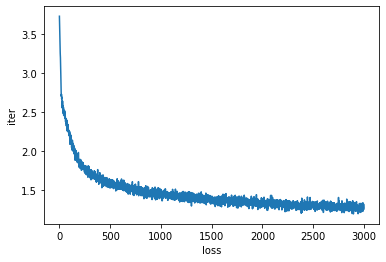

In [99]:
hist = []
max_len = 56
n_iter = 3000
batch_len = 30

for i in range(n_iter):
    batch_ix = to_matrix(sample(lines, batch_len), max_len)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    #initial hidden state: zero tensor shape=(1, batch_len, default rnn_num_units)
    h_state = torch.zeros(1, batch_len, 64)
    logp_seq = model(batch_ix, h_state)[0]
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    hist.append(loss.data.numpy())
    if (i + 1) % (n_iter * 0.1) == 0:
        plot_loss(hist)

#assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge.

In [100]:
print(np.mean(hist[2800:3000]))

1.2825229


In [104]:
def generate_sample(char_rnn, seed_phrase='shall', max_length=56, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #initial hidden state: zero tensor shape=(1, batch_len, default rnn_num_units)
    h_state = torch.zeros(1, 1, 64)
    if len(seed_phrase) > 1:
        _, h_state = char_rnn(x_sequence[:, :-1], h_state)
    #start generating
    for cur_id in range(max_length - len(seed_phrase)):
        log, h_state = char_rnn(x_sequence[:, -1].view(1, 1), h_state)
        p_next = F.softmax(log[:, -1]/ temperature, dim=-1).data.numpy()[0]
        #print(p_next)
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        #print(cur_id, ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]]))
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Romantic samples

In [ ]:
for item in ["love", "hope", "who", "pain"]:
    print(generate_sample(model, seed_phrase=item, temperature=0.5, max_length = 50))


love heand thee my me leath to uncuar his filt my 
hope thou bost the me the by hear with of say the 
whon gave thin the will,
                         
pain shath proms the sould deares andent fait the 


Examples with different temperature parameters

In [ ]:
generate_sample(model, seed_phrase="i ", temperature=0.5, max_length = 20)

[1.88378699e-08 1.05618592e-03 3.67795110e-07 5.63411413e-05
 3.35934089e-08 2.68804801e-09 4.08919323e-06 3.07839940e-07
 7.10523054e-08 6.75918628e-08 4.80705253e-08 2.18393943e-08
 1.49400700e-02 1.30307138e-01 1.39702186e-02 4.48487550e-02
 1.31549942e-03 1.01686165e-01 2.08789464e-02 5.11515662e-02
 7.33350962e-03 6.36335346e-04 1.67545117e-03 2.57077999e-02
 7.36390501e-02 1.83861889e-02 2.16379715e-03 6.42808378e-02
 9.76252195e-05 4.39411541e-03 2.31237292e-01 1.33606955e-01
 1.93507833e-04 9.53483221e-04 5.35878055e-02 3.51846445e-08
 1.89027668e-03 3.31784840e-08]
0 i t
[5.8356942e-10 5.5046448e-06 3.7880072e-09 1.1918044e-08 1.2671154e-10
 5.3336228e-11 1.0095848e-07 1.9708002e-09 1.7569328e-09 3.4408523e-09
 4.5745954e-10 8.9097668e-10 3.8722463e-04 4.6879163e-09 7.1299617e-08
 2.6479300e-11 1.0035062e-03 5.7169036e-08 8.5732776e-10 9.6384490e-01
 1.0963907e-03 5.7143388e-09 3.4501532e-08 9.7250686e-06 1.2924805e-08
 2.9343730e-07 3.0623943e-02 1.6094640e-07 5.9304459e-09 2

'i thee the so make r'

In [ ]:
generate_sample(model, seed_phrase="i ", temperature=1.0, max_length = 20)

[3.23682798e-05 9.58561711e-03 1.24097875e-04 1.98621559e-03
 2.50852208e-05 6.71772295e-06 6.70923328e-04 1.10015520e-04
 7.34028072e-05 5.43932183e-05 5.59086257e-05 3.17303566e-05
 3.72452997e-02 6.73138127e-02 2.73220707e-02 4.77046780e-02
 1.38040008e-02 5.63419014e-02 3.27850468e-02 6.98058903e-02
 2.52948739e-02 4.40644799e-03 7.57265091e-03 4.84849699e-02
 5.85976951e-02 3.32070999e-02 1.75375715e-02 6.61337972e-02
 2.00720923e-03 2.88551673e-02 1.14922926e-01 1.24966629e-01
 6.37885509e-03 5.56726335e-03 8.01919401e-02 4.36880109e-05
 1.07091442e-02 4.29207066e-05]
0 i p
[1.2206257e-06 4.7567926e-05 2.0065020e-06 5.6885765e-05 1.7030766e-06
 8.9786397e-07 1.3919187e-05 1.1152545e-05 2.4800563e-06 3.1208556e-06
 1.7158349e-06 1.4228257e-06 1.7301150e-01 6.3165615e-04 4.2066895e-04
 2.5878689e-05 9.8738208e-02 2.2479433e-04 1.1288669e-05 1.0336462e-02
 7.1952634e-02 5.1504416e-05 8.9740439e-05 3.8671605e-02 4.1870595e-04
 2.2385092e-03 1.3181992e-01 3.5936423e-03 6.9008121e-05 4

'i peane feel\n       '

As the temperature parameter increases, probas for diff tokens become closer (max : min for temperature=0.5 >> max:min for temperature=1.0 ) after applying softmax and model can generate more diverse samples

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [110]:
# Your beautiful code here
class LSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=24, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=2)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_n, c_n):
        #print(x.data)
        assert isinstance(x.data, torch.LongTensor)
        h_seq, (h_n, c_n) = self.rnn(self.emb(x), (h_n, c_n))
        logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(logits, dim=-1)
        return next_logp, (h_n, c_n)

In [111]:
adv_model = LSTMLoop()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(adv_model.parameters())

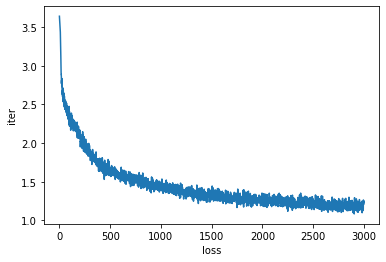

In [112]:
hist = []
max_len = 56
n_iter = 3000
batch_len = 20

for i in range(n_iter):
    batch_ix = to_matrix(sample(lines, batch_len), max_len)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    #initial hidden state: zero tensor shape=(2, batch_len, default rnn_num_units)
    h_0 = torch.zeros(2, batch_len, 64)
    c_0 = h_0
    logp_seq = adv_model(batch_ix, h_0, c_0)[0]
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    hist.append(loss.data.numpy())
    if (i + 1) % (n_iter * 0.1) == 0:
        plot_loss(hist)

#assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge.

In [113]:
print(np.mean(hist[2800:3000]))

1.187109


Final loss improved by 10% comparing with vanilla RNN for 3000 iterations, but I changed some other hyperparameters, for example, number of layers which causes better performance for second model

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [118]:
def generate_sample(char_rnn, seed_phrase='shall', max_length=56, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #initial hidden state: zero tensor shape=(1, batch_len, default rnn_num_units)
    h_n = torch.zeros(2, 1, 64)
    c_n = h_n
    if len(seed_phrase) > 1:
        _, (h_n, c_n) = char_rnn(x_sequence[:, :-1], h_n, c_n)
    #start generating
    for cur_id in range(max_length - len(seed_phrase)):
        log, (h_n, c_n) = char_rnn(x_sequence[:, -1].view(1, 1), h_n, c_n)
        p_next = F.softmax(log[:, -1]/ temperature, dim=-1).data.numpy()[0]
        #print(p_next)
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        #print(cur_id, ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]]))
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [120]:
# Text generation with different temperature values here
for item in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(item, ":", generate_sample(adv_model, seed_phrase="i ", temperature=item, max_length = 50))

0.1 : i shall the see the strange the will shall still,

0.2 : i my summer that heart the praise thee be thee,
  
0.5 : i love than the a virdet be though time thy stray,
1.0 : i suill his my love onober-and fieved,
           
2.0 : i ad, mest oof ount the hive a droofs,
 t  ,      


Small temperature: model almost repeats training data not produce poetry itself, high temperature: model generates diverse samples, it gains "imagination" but it is less similar to real language. Temperature 0.5 is optimal

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [54]:
# Saving and loading code here
torch.save(model.state_dict(), 'vanilla_rnn')

In [61]:
model1 = CharRNNLoop()
model1.load_state_dict(torch.load('vanilla_rnn'))
model1.eval()
print(generate_sample(model1, seed_phrase="you", temperature=0.5, max_length = 50))

youn thy death my love thou make wais in the deart


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)